In [450]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [451]:
SOLVER_VERSION = "data-collection-3"

In [452]:
df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")

In [453]:
solver_df = pd.merge(df[df.solver_version == SOLVER_VERSION], input_df, how="left", on="input_file")
solver_df

,input_file,solver_version,score,duration,query_count,n,m,eps,dense
0,tools/in/0000.txt,data-collection-3,0.707107,3.1395,7,15,2,0.01,0.168889
1,tools/in/0001.txt,data-collection-3,6.337479,16.4577,48,13,6,0.04,0.159763
2,tools/in/0002.txt,data-collection-3,4.230085,12.1795,30,13,2,0.07,0.402367
3,tools/in/0003.txt,data-collection-3,2.356660,9.1322,20,19,2,0.08,0.315789
4,tools/in/0004.txt,data-collection-3,25.692689,27.5753,153,16,8,0.14,0.367188
...,...,...,...,...,...,...,...,...,...
4995,tools/in/4995.txt,data-collection-3,14.071247,21.1922,67,12,4,0.16,0.527778
4996,tools/in/4996.txt,data-collection-3,6.581316,16.8923,48,17,5,0.10,0.404844
4997,tools/in/4997.txt,data-collection-3,4.189425,14.7291,38,17,7,0.02,0.487889
4998,tools/in/4998.txt,data-collection-3,34.539333,31.7246,187,11,5,0.12,0.206612


In [454]:
num_cols = ["score", "duration", "n", "m", "eps", "dense", "query_count"]
solver_df[num_cols].corr()

,score,duration,n,m,eps,dense,query_count
score,1.000000,0.541031,0.193955,0.433099,0.283582,-0.143238,0.694027
duration,0.541031,1.000000,0.457516,0.768269,0.466146,-0.207398,0.885211
n,0.193955,0.457516,1.000000,0.578898,-0.008796,0.015039,0.482696
m,0.433099,0.768269,0.578898,1.000000,-0.028503,-0.027349,0.775715
eps,0.283582,0.466146,-0.008796,-0.028503,1.000000,-0.025178,0.376101
dense,-0.143238,-0.207398,0.015039,-0.027349,-0.025178,1.000000,-0.167504
query_count,0.694027,0.885211,0.482696,0.775715,0.376101,-0.167504,1.000000


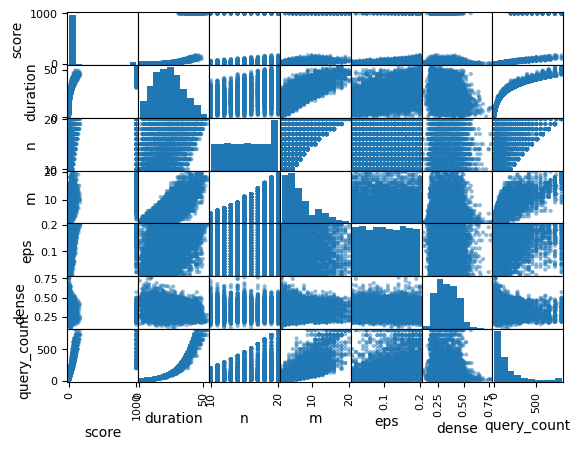

In [455]:
_ = pd.plotting.scatter_matrix(solver_df[num_cols])

In [456]:
def read_input(seed: int):
    with open(f"../tools/in/{seed:04}.txt", "r") as f:
        n, m, eps = f.readline().split()
        n, m, eps = int(n), int(m), float(eps)
        ds = []
        minos = []
        dense = 0
        for _ in range(m):
            s = f.readline().split()
            d, v = int(s[0]), list(map(int, s[1:]))
            v = [(v[2 * i], v[2 * i + 1]) for i in range(d)]
            ds.append(d)
            minos.append(v)
            dense += d
        dense /= n * n

    return n, m, eps, ds, minos, dense

In [457]:
# div = 4

# ratio_feats = []

# for seed in tqdm(range(len(solver_df))):
#     n, m, eps, ds, minos, dense = read_input(seed)

#     sizes = [(max(map(lambda p: p[0], mino)), max(map(lambda p: p[1], mino))) for mino in minos]

#     ratios = []
#     for j, mino2 in enumerate(minos):
#         s = set(mino2)
#         for i, mino1 in enumerate(minos):
#             if i <= j:
#                 continue
#             max_cnt = 0
#             for di in range(-sizes[i][0], sizes[j][0]):
#                 for dj in range(-sizes[i][1], sizes[j][1]):
#                     cnt = 0
#                     for p in mino1:
#                         v = (p[0] + di, p[1] + dj)
#                         if v in s:
#                             cnt += 1
#                     max_cnt = max(max_cnt, cnt)
#             if max_cnt == len(mino1):
#                 continue
#             ratios.append(max_cnt / len(mino1))

#     ratios.sort()
#     # ratio_ave = sum(ratios) / len(ratios)
#     ratio_max = max(ratios)
#     # ratio_feat = [ratio_ave, ratio_max] + [ratios[len(ratios) * i // div] for i in range(1, div)]
#     ratio_feat = [ratio_max]
#     ratio_feats.append(ratio_feat)

In [458]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression, Lasso

df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")
solver_df = pd.merge(df[df.solver_version == SOLVER_VERSION], input_df, how="left", on="input_file")

# ratio_cols = [f"ratio_feat_{i}" for i in range(len(ratio_feats[0]))]
# ratios_df = pd.DataFrame(ratio_feats, index=solver_df.index, columns=ratio_cols)
# solver_df = pd.concat([solver_df, ratios_df], axis=1)
solver_df.loc[:, ["mino_size"]] = solver_df.dense * (solver_df.n ** 2) / solver_df.m
solver_df.head()

,input_file,solver_version,score,duration,query_count,n,m,eps,dense,mino_size
0,tools/in/0000.txt,data-collection-3,0.707107,3.1395,7,15,2,0.01,0.168889,19.00
1,tools/in/0001.txt,data-collection-3,6.337479,16.4577,48,13,6,0.04,0.159763,4.50
2,tools/in/0002.txt,data-collection-3,4.230085,12.1795,30,13,2,0.07,0.402367,34.00
3,tools/in/0003.txt,data-collection-3,2.356660,9.1322,20,19,2,0.08,0.315789,57.00
4,tools/in/0004.txt,data-collection-3,25.692689,27.5753,153,16,8,0.14,0.367188,11.75


In [470]:
solver_df.groupby(["m", "eps"]).query_count.agg(
    ["max", "median", "min"]
).reset_index().pivot_table(["max", "median", "min"], "m", "eps")

max                                                                 \
eps   0.01   0.02   0.03   0.04   0.05   0.06   0.07   0.08   0.09   0.10   
m                                                                           
2     13.0   17.0   26.0   38.0   34.0   34.0   38.0   48.0   38.0  113.0   
3     20.0   30.0   30.0   38.0   67.0   67.0   54.0   83.0   75.0   75.0   
4     26.0   43.0   38.0   43.0   67.0   67.0  153.0  113.0  125.0  138.0   
5     48.0   48.0   67.0   60.0   75.0  187.0  113.0  125.0  125.0  308.0   
6     43.0   48.0   75.0   92.0   83.0  113.0  153.0  138.0  187.0  187.0   
7     67.0   75.0   83.0  288.0  102.0  125.0  138.0  187.0  279.0  187.0   
8     67.0  338.0  113.0  153.0  125.0  138.0  279.0  308.0  308.0  340.0   
9     92.0  113.0  113.0  153.0  113.0  253.0  229.0  340.0  229.0  392.0   
10   125.0  125.0  113.0  138.0  125.0  153.0  187.0  229.0  413.0  450.0   
11   102.0  153.0  187.0  253.0  229.0  253.0  308.0  450.0  375.0  308.0   
12   113.0  169.0  169.0  229.0  253.0  253.0  375.0  279.0  375.0  308.0   
13   125.0  153.0  253.0  648.0  279.0  375.0  375.0  413.0  413.0  501.0   
14   187.0  229.0  187.0  279.0  308.0  279.0  455.0  608.0  608.0  501.0   
15   187.0  308.0  253.0  375.0  279.0  455.0  648.0  413.0  800.0  648.0   
16   308.0  279.0  413.0  413.0  608.0  722.0    NaN  552.0  800.0  608.0   
17   308.0  229.0  413.0  800.0  722.0  670.0  800.0  800.0  722.0  670.0   
18   501.0  800.0  800.0  552.0  800.0  413.0  800.0  722.0  722.0  722.0   
19   413.0  279.0  608.0  279.0  800.0  608.0  800.0  800.0  800.0  800.0   
20     NaN  800.0    NaN  501.0  800.0  800.0    NaN  800.0    NaN  800.0   

     ...    min                                                                 
eps  ...   0.11   0.12   0.13   0.14   0.15   0.16   0.17   0.18   0.19   0.20  
m    ...                                                                        
2    ...    3.0    3.0    3.0    3.0    7.0    3.0    5.0    3.0    9.0    3.0  
3    ...   11.0   20.0   17.0   13.0   20.0    9.0   15.0    7.0   13.0   38.0  
4    ...   23.0   30.0   26.0   23.0   34.0   43.0   38.0   23.0   48.0   54.0  
5    ...   30.0   34.0   43.0   43.0   43.0   43.0   67.0   83.0   60.0   67.0  
6    ...   54.0   54.0   54.0   60.0   83.0   92.0   92.0  102.0   92.0   75.0  
7    ...   54.0   75.0   83.0   83.0   75.0  153.0  102.0  113.0   92.0  125.0  
8    ...  102.0   75.0  113.0  113.0  125.0  113.0  153.0  125.0  187.0  125.0  
9    ...  113.0  125.0  125.0  153.0  207.0  207.0  187.0  229.0  229.0  253.0  
10   ...  113.0  125.0  138.0  187.0  153.0  207.0  229.0  229.0  279.0  308.0  
11   ...  153.0  207.0  169.0  229.0  207.0  279.0  229.0  413.0  229.0  308.0  
12   ...  187.0  169.0  229.0  279.0  207.0  340.0  413.0  253.0  552.0  308.0  
13   ...  207.0  308.0  253.0  279.0  375.0  375.0  340.0  552.0  455.0  501.0  
14   ...  308.0  253.0  375.0  413.0  413.0  340.0  578.0  455.0  608.0  340.0  
15   ...  308.0  413.0  722.0  455.0  279.0  375.0  501.0  455.0  800.0  648.0  
16   ...  608.0  375.0  552.0  648.0  648.0  413.0  648.0  648.0  722.0  648.0  
17   ...  552.0  800.0  670.0  501.0  552.0  800.0  670.0  722.0  800.0  722.0  
18   ...  800.0  800.0    NaN  800.0  722.0  608.0  722.0  800.0  800.0  722.0  
19   ...  800.0  800.0  800.0  800.0    NaN    NaN  800.0  738.0  800.0    NaN  
20   ...  800.0  800.0  800.0  800.0  670.0  800.0    NaN    NaN  800.0  800.0  

[19 rows x 60 columns]

In [460]:
# solver_df = solver_df.groupby(["n", "m", "eps"])[["query_count", "score", "duration"]].median().reset_index()
# solver_df

In [461]:
# solver_df[num_cols + ratio_cols].corr()

In [462]:
alphas = [0.5, 2.0]

data_df = solver_df.copy(deep=True)
data_df.loc[:, ["target"]] = data_df["query_count"]

data_df = data_df.drop(["input_file", "solver_version", "score", "duration", "query_count"], axis=1)

feature_cols = []

base_feature_cols = ["n", "m", "eps", "dense", "mino_size"]

# 特徴量
for col in base_feature_cols:
    feature_cols.append(f"{col}.ln()")
    data_df.loc[:, [f"{col}.ln()"]] = np.log(data_df[col])

    for alpha in alphas:
        feature_cols.append(f"{col}.powf({alpha})")
        data_df.loc[:, [f"{col}.powf({alpha})"]] = data_df[col] ** alpha

# feature_cols += ratio_cols

for col1 in feature_cols:
    for col2 in feature_cols:
        data_df.loc[:, [f"{col1} * {col2}"]] = data_df[col1] * data_df[col2]
        data_df.loc[:, [f"{col1} / {col2}"]] = data_df[col1] / data_df[col2]

x = data_df.drop(["target"], axis=1)
y = data_df["target"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

model = Ridge(alpha=1e-4)
model.fit(train_x, train_y)

# print(model.coef_)
# print(model.intercept_)
print(len(model.coef_))
print(len(list(filter(lambda x: abs(x) > 1e-10, model.coef_))))
print(model.score(train_x, train_y))
print(model.score(test_x, test_y))
expr = " + ".join([f"{c:.5} * {t}" for c, t in zip(model.coef_.flatten(), x.columns)]) + f" + {model.intercept_:.5}"
print(expr)
with open("../log/expr.txt", "w") as f:
    f.write(expr + "\n")

470
470
0.8976178665851234
0.8877920553354096
623.33 * n + -931.57 * m + 896.27 * eps + -698.29 * dense + -242.21 * mino_size + 478.66 * n.ln() + 336.04 * n.powf(0.5) + -792.79 * n.powf(2.0) + 1065.9 * m.ln() + 111.03 * m.powf(0.5) + 2089.5 * m.powf(2.0) + 557.67 * eps.ln() + 434.36 * eps.powf(0.5) + 861.42 * eps.powf(2.0) + -776.85 * dense.ln() + -459.84 * dense.powf(0.5) + -188.65 * dense.powf(2.0) + -885.6 * mino_size.ln() + -301.8 * mino_size.powf(0.5) + 197.24 * mino_size.powf(2.0) + 886.17 * n.ln() * n.ln() + 0.0073452 * n.ln() / n.ln() + 797.92 * n.ln() * n.powf(0.5) + 104.34 * n.ln() / n.powf(0.5) + 123.0 * n.ln() * n.powf(2.0) + -68.993 * n.ln() / n.powf(2.0) + 573.45 * n.ln() * m.ln() + 942.02 * n.ln() / m.ln() + -1240.2 * n.ln() * m.powf(0.5) + -330.9 * n.ln() / m.powf(0.5) + -173.98 * n.ln() * m.powf(2.0) + 103.87 * n.ln() / m.powf(2.0) + 1114.7 * n.ln() * eps.ln() + 719.76 * n.ln() / eps.ln() + -563.81 * n.ln() * eps.powf(0.5) + 800.2 * n.ln() / eps.powf(0.5) + -109.97 * n

    43 71.47741061542911
   102 101.57354124280027
   455 638.2542755193354
    75 128.03340876200855
   279 303.34531532292385
   113 140.40485515166438
   253 198.23522948173195
    75 101.26671226371218
   552 488.6704109215607
   102 63.71054758047649


[-31.274591930205133, 837.9902848065522]

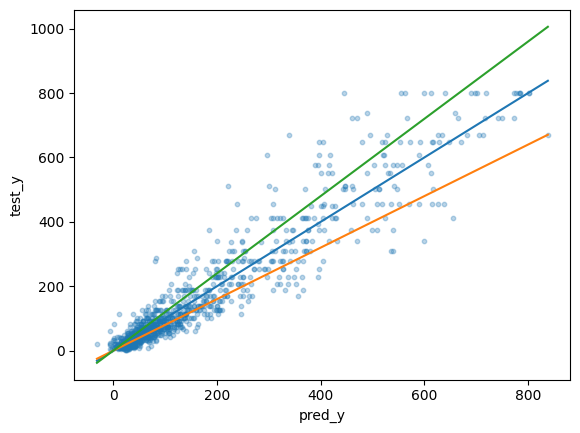

In [463]:
pred_y = model.predict(test_x)
for i in range(100, 110):
    print(f"{test_y.iloc[i]:6} {pred_y[i]}")

plt.scatter(pred_y, test_y, alpha=0.3, s=10)
plt.xlabel("pred_y")
plt.ylabel("test_y")
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min(), pred_y.max()])
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min() * 0.8, pred_y.max() * 0.8])
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min() * 1.2, pred_y.max() * 1.2])
# plt.xlim(0, 100)
# plt.ylim(0, 100)
[pred_y.min(), pred_y.max()]

In [464]:
# import torch


# class Model(torch.nn.Module):
#     def __init__(self, n_feature: int, d_model: int):
#         super().__init__()
#         self.layers = torch.nn.Sequential(
#             torch.nn.Linear(n_feature, d_model),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(d_model, d_model),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(d_model, d_model),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(d_model, 1),
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.layers.forward(x)


# train_dataset = torch.utils.data.TensorDataset(
#     torch.Tensor(train_x.values), torch.Tensor(train_y.values)
# )

# model = Model(n_feature=train_x.shape[1], d_model=64)
# model.train()

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# data_loader = torch.utils.data.DataLoader(
#     dataset=train_dataset, shuffle=True, batch_size=16
# )

# losses = []

# for i in tqdm(range(100)):
#     loss_sum = 0
#     for X, y in data_loader:
#         optimizer.zero_grad()
#         y_hat = model.forward(X)
#         loss = criterion(y_hat, y)
#         loss.backward()
#         optimizer.step()
#         loss_sum += loss.item()

#     if (i + 1) % 10 == 0:
#         loss_sum /= len(data_loader)
#         losses.append(loss_sum)

# pred_y = model.forward(torch.Tensor(test_x.values)).detach().numpy()
# print(pred_y[:10], test_y[:10].values)
# plt.scatter(test_y, pred_y)
# plt.show()
# plt.plot(losses)
# plt.show()

In [465]:
import lightgbm as lgb
from sklearn.metrics import r2_score

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "random_state": 0,
    "verbose": -1
}

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0)
train_set = lgb.Dataset(train_x, train_y)
valid_set = lgb.Dataset(valid_x, valid_y, reference=train_set)

model = lgb.train(params=params, train_set=train_set, valid_sets=[valid_set], num_boost_round=1000)

pred_y = model.predict(test_x, num_iteration=model.best_iteration)
print(r2_score(test_y, pred_y))

0.8678609154503927


[2.8090085973313474, 863.2229672492307]

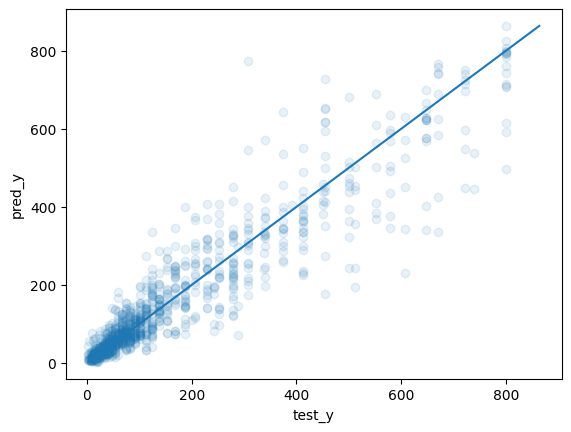

In [466]:
plt.scatter(test_y, pred_y, alpha=0.1)
plt.xlabel("test_y")
plt.ylabel("pred_y")
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min(), pred_y.max()])
[pred_y.min(), pred_y.max()]